## CNN with MobileNet model

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

2023-05-28 15:59:24.395205: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2023-05-28 15:59:48.709458: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 15:59:48.709981: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-28 15:59:48.710529: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-28 15:59:48.720649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-28 15:59:48.720748: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 na

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


2023-05-28 16:00:09.781446: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-28 16:00:09.781611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-28 16:00:09.781717: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.635GHz coreCount: 14 deviceMemorySize: 3.81GiB deviceMemoryBandwidth: 178.84GiB/s
2023-05-28 16:00:09.781741: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-28 16:00:09.781762: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-28 16:00:09.781772: I tensorflow/stream_executor/platform

MobileNets are a class of small, low-latency, low-power models that can be used for classification, detection, and other common tasks convolutional neural networks are good for. Because of their small size, these are considered great deep learning models to be used on mobile devices.

To give a quick comparison in regards to size, the size of the full VGG16 network on disk is about **553 megabytes**. The size of one of the currently largest MobileNets is about **17 megabytes**.

This vast size difference is due to the number of parameters within these networks. For example, VGG16 has **138 million parameters**, while the 17 megabyte MobileNet we just mentioned has **only 4.2 million**.


In [4]:
#We download the mobile model
mobile = tf.keras.applications.mobilenet.MobileNet()


2023-05-28 16:03:32.288774: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-28 16:03:32.288951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-28 16:03:32.289055: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.635GHz coreCount: 14 deviceMemorySize: 3.81GiB deviceMemoryBandwidth: 178.84GiB/s
2023-05-28 16:03:32.289078: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-28 16:03:32.289099: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-28 16:03:32.289108: I tensorflow/stream_executor/platform

17227776/17225924 [==============================] - 1s 0us/step


In [14]:
#Checking the mobile model
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [6]:
# accepts an image file, and processes the image to get it in a format that the model expects.
def prepare_image(file):
    img_path = '../data/MobileNet-samples/'
    img = image.load_img(img_path + file, target_size=(224, 224))   # Default size for mobileNet is 224x224
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)
# preprocess_input() from tf.keras.applications.mobilenet, preprocesses the given image data to be in the same format as the images that MobileNet was originally trained on. Specifically, it's scaling the pixel values in the image between -1 and 1

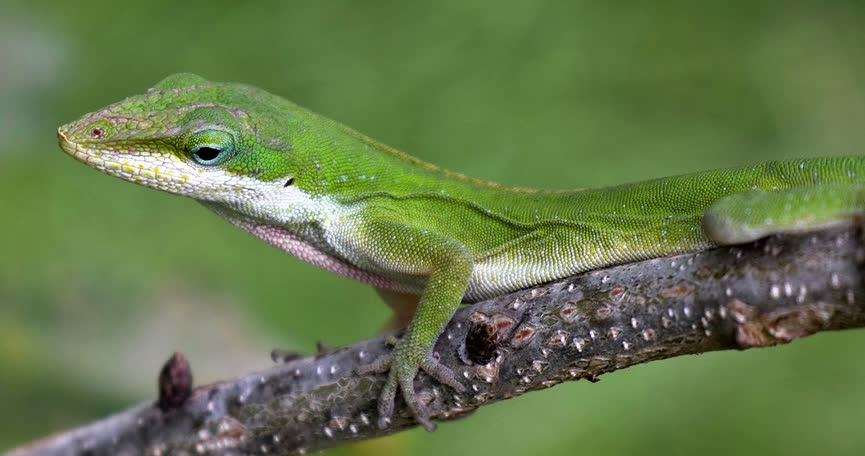

In [12]:
#we are going to process the following image by passing it to the prepare_image() function

from IPython.display import Image
Image(filename='../data/MobileNet-samples/1.png', width=300,height=200) 

In [13]:
# Now, we're then having MobileNet predict on this image by calling mobile.predict() and passing it our preprocessed_image.

preprocessed_image = prepare_image('1.png')
predictions = mobile.predict(preprocessed_image)

2023-05-28 16:27:39.332755: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-28 16:27:39.333090: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 4099895000 Hz
2023-05-28 16:27:39.597042: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-05-28 16:27:40.276698: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-05-28 16:27:40.313377: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-05-28 16:27:40.579208: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-28 16:27:43.809212: I tensorflow/stream

In [16]:
# decode_predictions() is a function provided by Keras that returns the top five ImageNet class predictions with the ImageNet class ID, the class label, and the probability

results = imagenet_utils.decode_predictions(predictions)
print(results)

[[('n01682714', 'American_chameleon', 0.65277255), ('n01693334', 'green_lizard', 0.18930103), ('n01687978', 'agama', 0.13809675), ('n01689811', 'alligator_lizard', 0.013602625), ('n01688243', 'frilled_lizard', 0.0043193423)]]


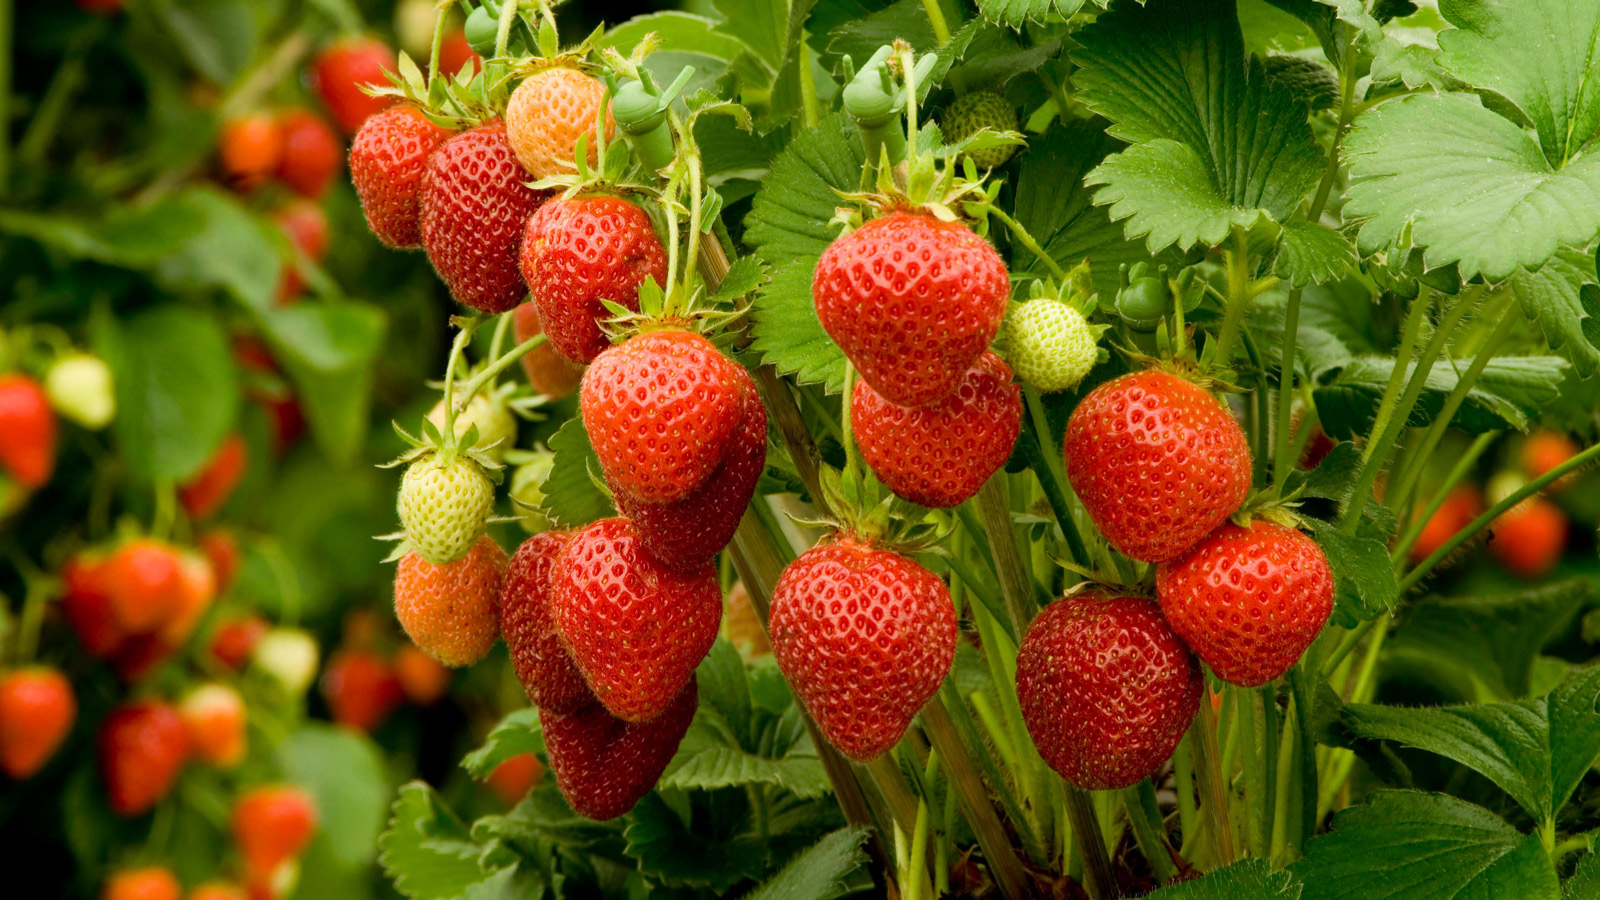

In [22]:
# now we'll try with another image
Image(filename='../data/MobileNet-samples/2.png', width=300,height=200)

In [23]:
preprocessed_image = prepare_image('2.png')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
print(results)

[[('n07745940', 'strawberry', 0.99842834), ('n07753275', 'pineapple', 0.00081675866), ('n07754684', 'jackfruit', 0.0003347422), ('n07749582', 'lemon', 0.00013447176), ('n07760859', 'custard_apple', 8.879323e-05)]]


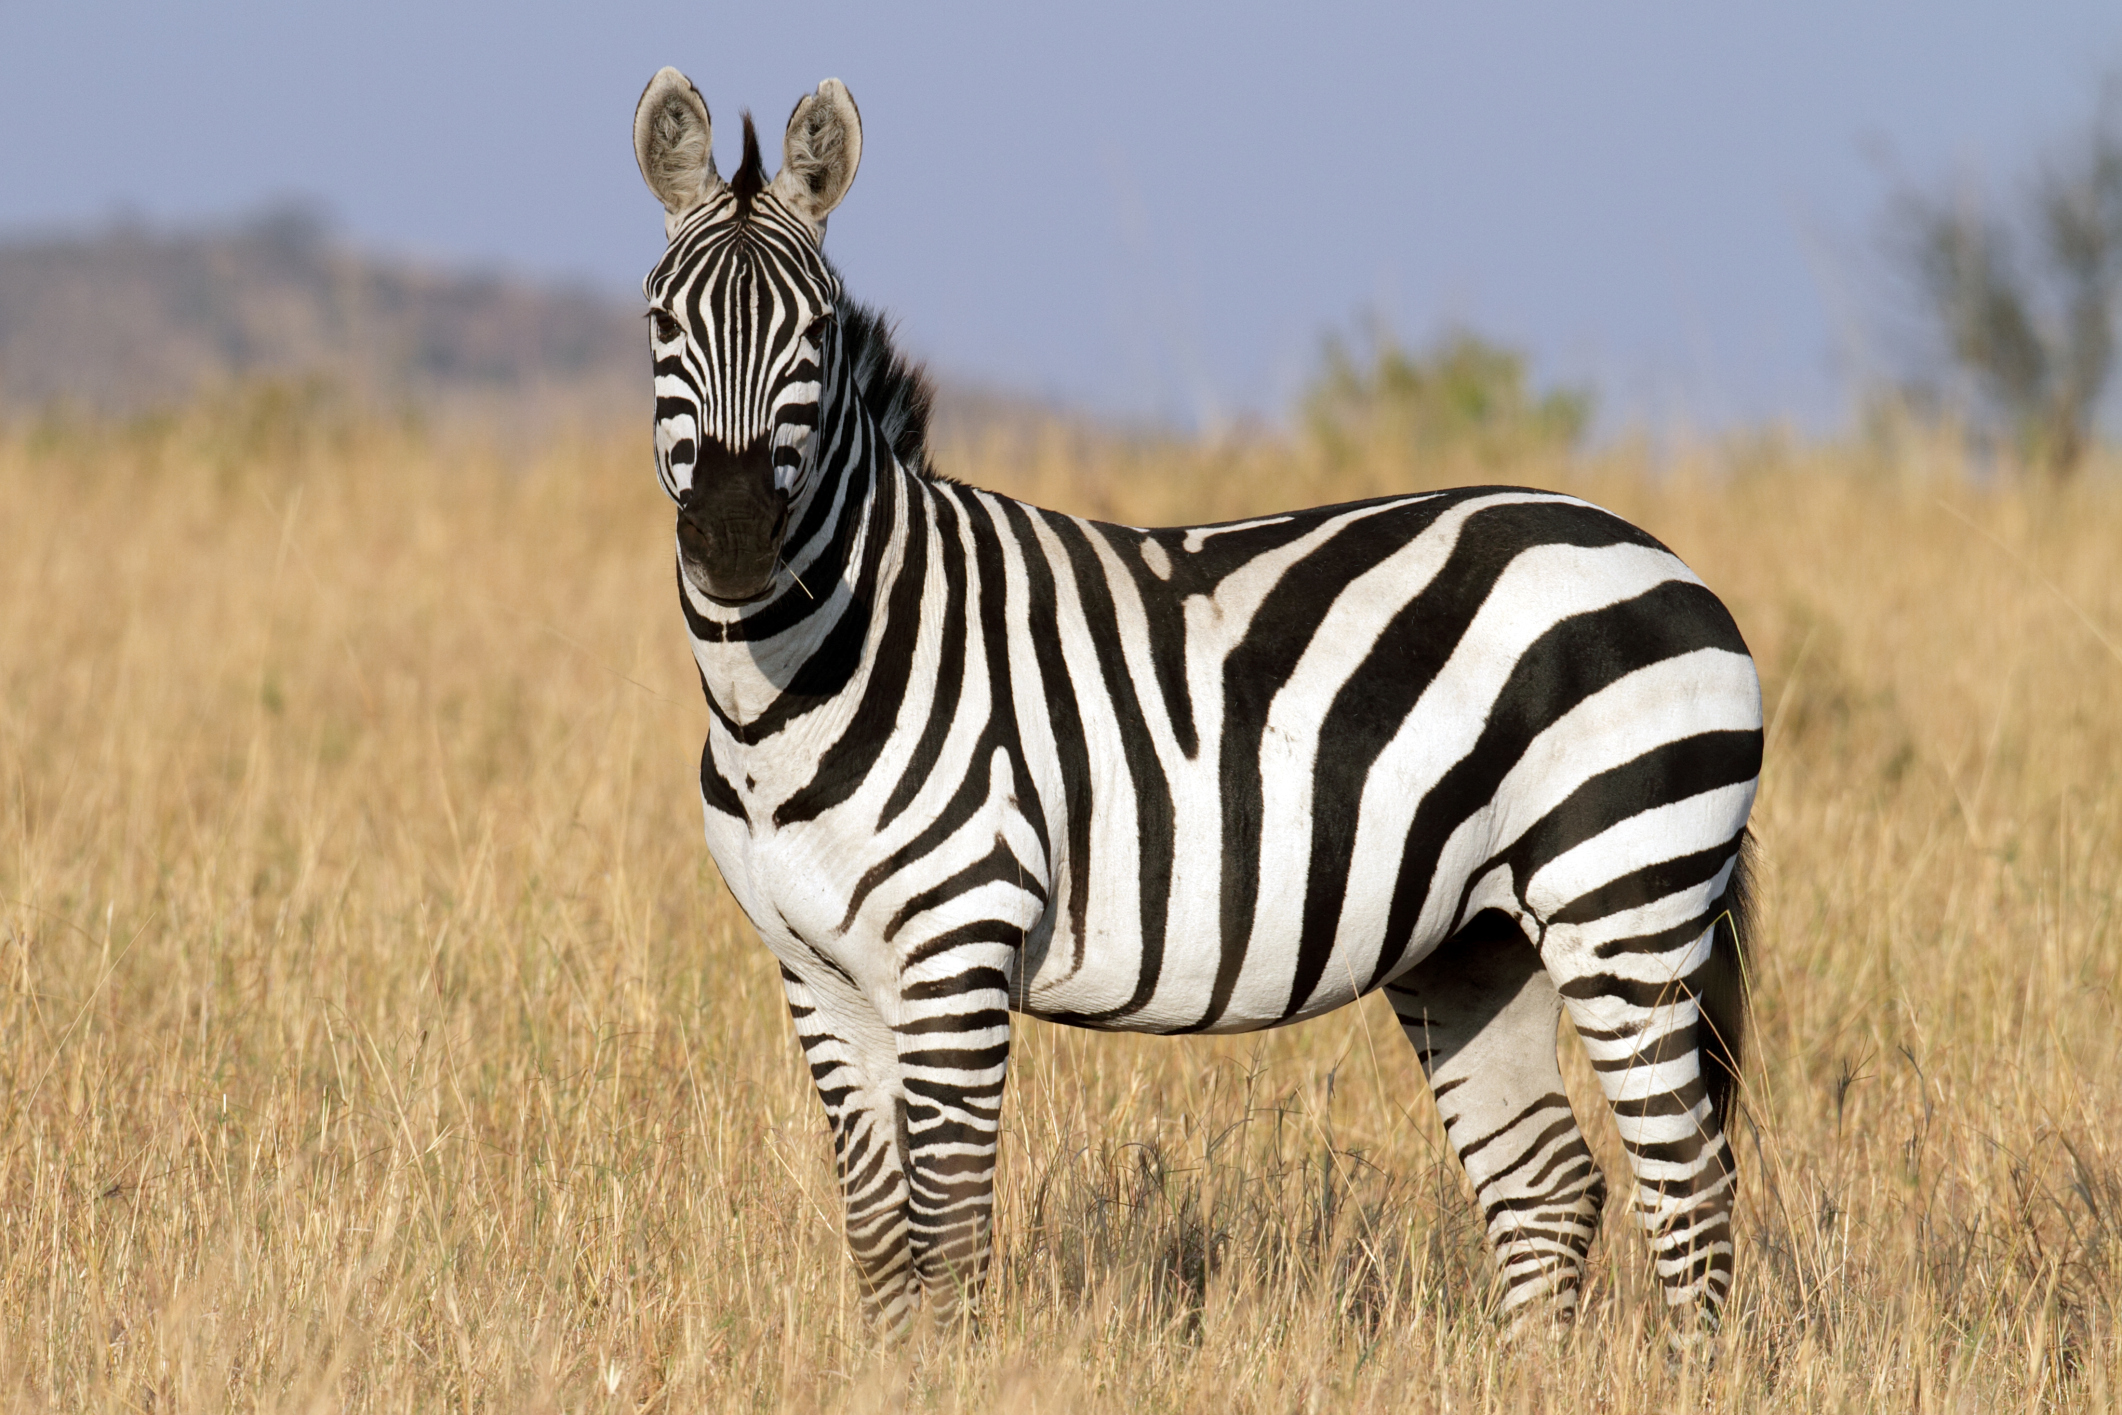

In [17]:
# now we'll try with another image
Image(filename='../data/MobileNet-samples/3.png', width=300,height=200) 

In [18]:
preprocessed_image = prepare_image('3.png')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
print(results)

[[('n02391049', 'zebra', 0.9999869), ('n02129604', 'tiger', 1.08271015e-05), ('n02123159', 'tiger_cat', 1.4541632e-06), ('n02423022', 'gazelle', 1.9825367e-07), ('n01675722', 'banded_gecko', 1.060709e-07)]]
